# LeNet5


* **Author** : Yalla Mahanth
* **SR No** : 24004

### imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime as dt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda')

### MNIST Dataset

In [3]:
mnist_data_folder = './../Data/MNIST/'
labels = np.arange(10)
mnist_train_images_file =  mnist_data_folder + f'train-images.idx3-ubyte'
mnist_train_labels_file =  mnist_data_folder + f'train-labels.idx1-ubyte'
mnist_test_images_file =  mnist_data_folder + f't10k-images.idx3-ubyte'
mnist_test_labels_file =  mnist_data_folder + f't10k-labels.idx1-ubyte'

# Reading from idx file function code snippet is taken from https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40#file-mnist-py
def read_idx(filename):
    import struct 
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

mnist_train_images = read_idx(mnist_train_images_file)
mnist_train_labels = read_idx(mnist_train_labels_file)
mnist_test_images = read_idx(mnist_test_images_file)
mnist_test_labels = read_idx(mnist_test_labels_file)

mnist_train_images.shape ,mnist_train_labels.shape,mnist_test_images.shape ,mnist_test_labels.shape
Xtr, Xval, ytr, yval = train_test_split(mnist_train_images, mnist_train_labels, test_size=0.2)
Xte , yte = mnist_test_images, mnist_test_labels
Xtr.shape, Xval.shape, ytr.shape, yval.shape, Xte.shape, yte.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

((48000, 28, 28),
 (12000, 28, 28),
 (48000,),
 (12000,),
 (10000, 28, 28),
 (10000,))

In [4]:
Xtr = torch.tensor(Xtr , dtype = torch.float32)
ytr = torch.tensor(ytr , dtype = torch.float32)
Xval = torch.tensor(Xval , dtype = torch.float32)
yval = torch.tensor(yval , dtype = torch.float32)
Xte = torch.tensor(Xte , dtype = torch.float32)
yte = torch.tensor(yte , dtype = torch.float32)

In [5]:
ytr_enc = torch.zeros(ytr.shape[0] , len(labels)) 
yval_enc = torch.zeros(yval.shape[0] , len(labels))
yte_enc = torch.zeros(yte.shape[0] , len(labels))

ytr_enc[torch.arange(ytr.shape[0]) , ytr.long()] = 1
yval_enc[torch.arange(yval.shape[0]) , yval.long()] = 1
yte_enc[torch.arange(yte.shape[0]) , yte.long()] = 1

In [6]:
Xtr[0].reshape((28,28)).shape , ytr_enc[0].shape 

(torch.Size([28, 28]), torch.Size([10]))

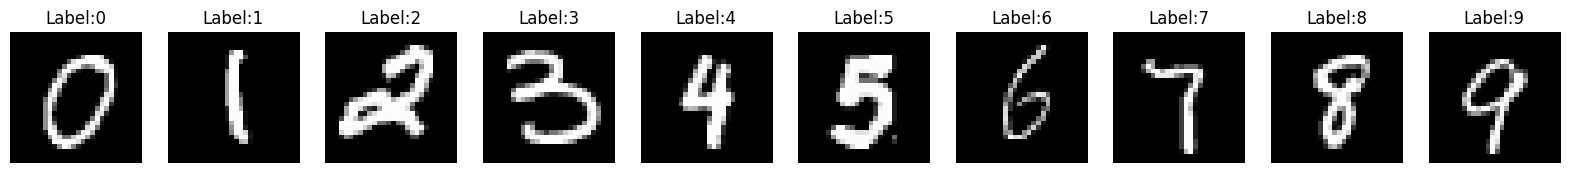

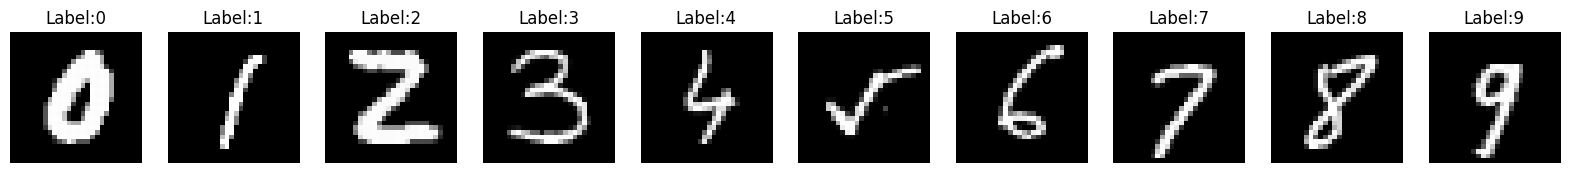

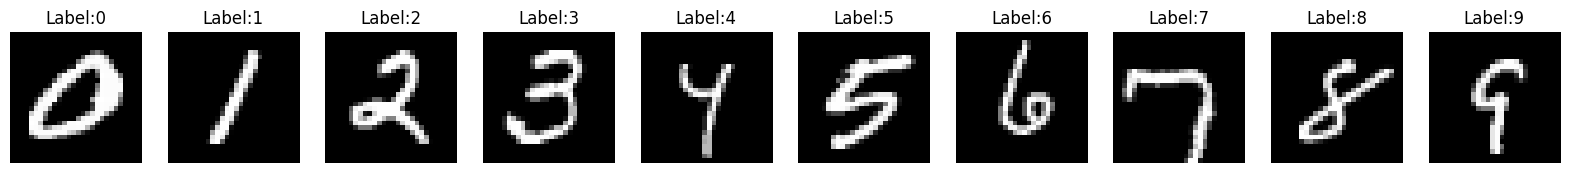

In [ ]:
class DatasetMNIST(Dataset):
    def __init__(self , X , y):
        self.X,self.y = X, y
        self.labels = np.sort(np.unique(y))
        self.n_classes = len(np.unique(y))
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self , idx):
        pixs = np.random.randint(1,4)
        X_i , y_i = self.random_agumentation(self.X[idx] , self.y[idx] , pixels = pixs)
        y_i = F.one_hot(y_i.long() , num_classes = self.n_classes).float()
        
        if device == 'cuda':
            X_i = X_i.cuda()
            y_i = y_i.cuda()
        
        return X_i , y_i
    
    def random_agumentation(self , X_i , y_i , pixels = 1):
        type = np.random.randint(1,8 *2 +1)
        if type == 1:
            X_Right_shifted = torch.roll(X_i , shifts = pixels , dims = 1)
            X_shifted = X_Right_shifted
        elif type == 2:
            X_Left_shifted = torch.roll(X_i , shifts = -pixels , dims = 1)
            X_shifted = X_Left_shifted
        elif type == 3:
            X_Up_shifted = torch.roll(X_i , shifts = pixels , dims = 0)
            X_shifted = X_Up_shifted
        elif type == 4:
            X_Down_shifted = torch.roll(X_i , shifts = -pixels , dims = 0)
            X_shifted = X_Down_shifted
        elif type == 5:
            X_Right_shifted = torch.roll(X_i , shifts = pixels , dims = 1)
            X_shifted = torch.roll(X_Right_shifted , shifts = pixels , dims = 0)
        elif type == 6:
            X_Left_shifted = torch.roll(X_i , shifts = -pixels , dims = 1)
            X_shifted = torch.roll(X_Left_shifted , shifts = -pixels , dims = 0)
        elif type == 7:
            X_Up_shifted = torch.roll(X_i , shifts = pixels , dims = 0)
            X_shifted = torch.roll(X_Up_shifted , shifts = -pixels , dims = 1)
        elif type == 8:
            X_Down_shifted = torch.roll(X_i , shifts = -pixels , dims = 0)
            X_shifted = torch.roll(X_Down_shifted , shifts = pixels , dims = 1)
        else:
            X_shifted = X_i
        
        return X_shifted , y_i
    
train_dataset = DatasetMNIST(Xtr , ytr)
len(train_dataset)

48000

In [12]:
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
Xb, yb = next(iter(dataloader))
Xb.shape, yb.shape

(torch.Size([64, 28, 28]), torch.Size([64, 10]))

(<matplotlib.image.AxesImage at 0x24f318c6a10>,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

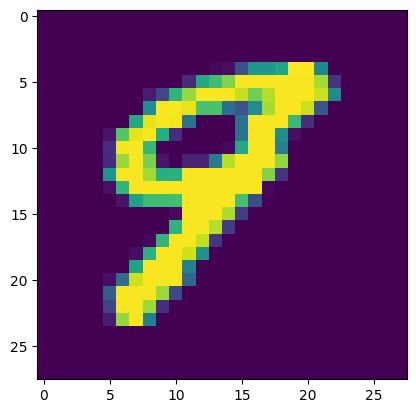

In [13]:
plt.imshow(Xb[0]), yb[0]

# Le Net 5 Architecture

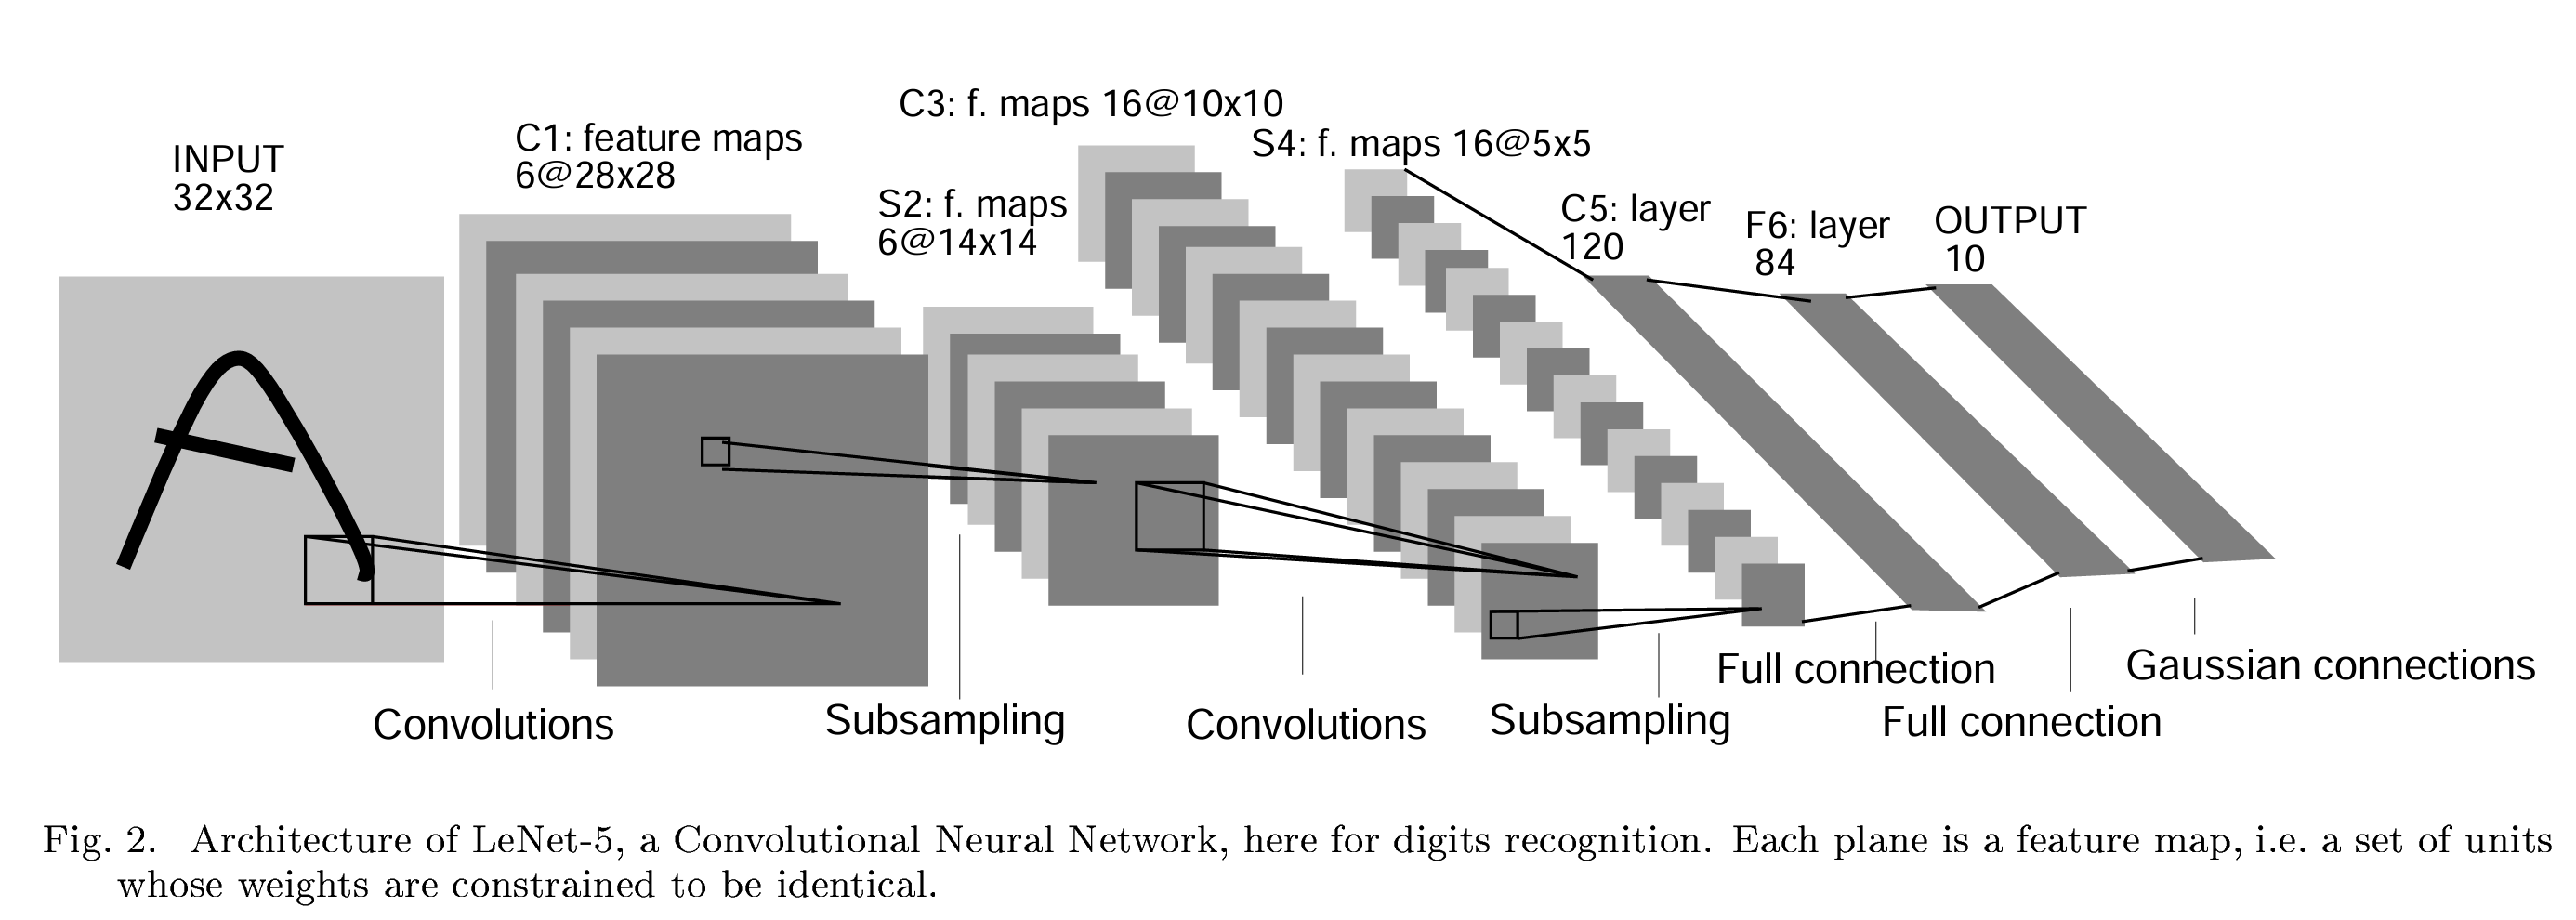

In [ ]:
class LeNet5(nn.Module):
    
    def __init__(self, inp_size, filters, f_sizes , n_classes):
        super(LeNet5,self).__init__() 
        
        self.conv1 = nn.Conv2d(inp_size, filters[0], kernel_size = f_sizes[0], stride = 1, padding = 2)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # self.pool1 = nn.AvgPool2d(kernel_size = 2, stride = 2)
        
        self.conv2 = nn.Conv2d(filters[0], filters[1], kernel_size = f_sizes[1], stride = 1, padding = 0)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(filters[1]*f_sizes[1]*f_sizes[1], 120 , bias = True )
        # self.fc1.requires_grad_(True)
        self.fc2 = nn.Linear(120, 84 , bias = True )
        # self.fc2.requires_grad_(True)
        self.fc3 = nn.Linear(84, n_classes, bias = True )
        # self.fc3.requires_grad_(True)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

    
    def predict_proba(self, x):
        x = self.forward(x)
        return F.softmax(x, dim = -1)

    def predict(self, x):
        x = self.predict_proba(x)
        return torch.argmax(x, dim = -1)
    
    def accuracy(self, x, y):
        y_pred = self.predict(x)
        return (y_pred == y).float().mean()
    
    
# Xb , yb = next(iter(dataloader))
# print(f'{Xb.shape = } , {yb.shape = }')
# lenet5 = LeNet5()
# lenet5.forward(Xb.reshape(-1,1,28,28)).shape
# lenet5.forward(Xb.reshape(-1,1,28,28))[0].shape

# def smax(x):
#     return torch.exp(x) / torch.exp(x).sum(axis = -1)

# smax(lenet5.forward(Xb.reshape(-1,1,28,28))[0])

# torch.softmax(lenet5.forward(Xb.reshape(-1,1,28,28)) , dim = -1)[0] , yb[0]

Xb.shape = torch.Size([64, 28, 28]) , yb.shape = torch.Size([64, 10])


torch.Size([64, 10])

torch.Size([10])

tensor([1.0254e-03, 2.7343e-02, 8.0022e-05, 2.6340e-03, 1.4953e-01, 1.4715e-01,
        2.1638e-03, 1.1350e-01, 2.1382e-03, 5.5443e-01],
       grad_fn=<DivBackward0>)

(tensor([1.0254e-03, 2.7343e-02, 8.0022e-05, 2.6340e-03, 1.4953e-01, 1.4715e-01,
         2.1638e-03, 1.1350e-01, 2.1382e-03, 5.5443e-01],
        grad_fn=<SelectBackward0>),
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

## LeNet5 Trainer

In [15]:
class LeNetTrainer():
    
    def __init__(self, model, optimiser, criterion, train_dataset_loader,valid_dataset_loader):
        self.model = model
        self.optimiser = optimiser
        self.criterion = criterion
        self.train_dataset_loader = train_dataset_loader
        self.valid_dataset_loader = valid_dataset_loader
        self.logs = {
            'train_epochs':[],
            'train_loss':[], 
            'valid_epochs':[],
            'valid_loss':[]
            }
        if device == 'cuda':
            self.model = self.model.cuda()
            print('[+] Model is moved to GPU')
        
    def train(self, n_epochs, validate_every = 10):
        for epoch in range(n_epochs):
            train_loss = self.training(epoch , n_epochs)
            self.logs['train_loss'].append(train_loss)
            self.logs['train_epochs'].append(epoch)
            if epoch == 0 or (epoch + 1) % validate_every == 0:
                valid_loss = self.validation(epoch , n_epochs)
                self.logs['valid_loss'].append(valid_loss)
                self.logs['valid_epochs'].append(epoch)
                print(f'Epoch {epoch+1:5d}/{n_epochs:5d} | Train Loss: {train_loss:.7f} | Valid Loss: {valid_loss:.7f}')
            else :
                print(f'Epoch {epoch+1:5d}/{n_epochs:5d} | Train Loss: {train_loss:.7f}')
    
    def training(self, epoch, n_epochs):
        self.model.train()
        total_loss = 0.0
        for Xb, yb in tqdm(self.train_dataset_loader, desc=f"Training Epoch {epoch+1}/{n_epochs}", unit='batch'):
            y_pred = self.model(Xb.reshape(-1,1,28,28))
            loss = self.criterion(y_pred, yb)
            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()
            total_loss += loss.item()
        return total_loss / len(self.train_dataset_loader)
   
    def validation(self, epoch, n_epochs):
        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for Xb, yb in tqdm(self.valid_dataset_loader, desc=f"Validation Epoch {epoch+1}/{n_epochs}", unit='batch'):
                y_pred = self.model(Xb.reshape(-1,1,28,28))
                loss = self.criterion(y_pred, yb)
                total_loss += loss.item()
        return total_loss / len(self.valid_dataset_loader)
    
    def plot_losses(self):
        plt.figure(figsize=(10,5))
        plt.plot(self.logs['train_epochs'], self.logs['train_loss'], label='Train Loss')
        plt.plot(self.logs['valid_epochs'], self.logs['valid_loss'], label='Valid Loss')
        plt.legend()
        plt.show()
    
    def accuracy(self, X, y):
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model.predict(X.reshape(-1,1,28,28))
            return (y_pred == y).float().mean()
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            return self.model.predict(X.reshape(-1,1,28,28))
    
    

In [ ]:
model = LeNet5(1 , (6,16) , (5,5) , 10)
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')
optimiser = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_dataset = DatasetMNIST(Xtr , ytr)
valid_dataset = DatasetMNIST(Xval , yval)

train_dataset_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataset_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

lenet5_trainer = LeNetTrainer(model, optimiser, criterion, train_dataset_loader, valid_dataset_loader)

Total number of parameters: 61706


In [17]:
before_training_acc = lenet5_trainer.accuracy(Xval, yval)
print(f'Accuracy before training: {before_training_acc:.2%}')

Accuracy before training: 7.60%


### Training

In [18]:
time_start = dt.now()

number_of_epochs = 10
validate_epochs = number_of_epochs // 2

lenet5_trainer.train(n_epochs=number_of_epochs, validate_every=validate_epochs)
print(f'[>] Training time: {dt.now() - time_start}')

Validation Epoch 1/10: 100%|██████████| 188/188 [00:01<00:00, 148.74batch/s]


Epoch     1/   10 | Train Loss: 0.2905005 | Valid Loss: 0.1364158


Training Epoch 2/10: 100%|██████████| 750/750 [00:21<00:00, 34.89batch/s]


Epoch     2/   10 | Train Loss: 0.1112108


Training Epoch 3/10: 100%|██████████| 750/750 [00:20<00:00, 36.69batch/s]


Epoch     3/   10 | Train Loss: 0.0865153


Training Epoch 4/10: 100%|██████████| 750/750 [00:23<00:00, 31.62batch/s]


Epoch     4/   10 | Train Loss: 0.0761598


Validation Epoch 5/10: 100%|██████████| 188/188 [00:01<00:00, 154.99batch/s]


Epoch     5/   10 | Train Loss: 0.0666245 | Valid Loss: 0.0820586


Training Epoch 6/10: 100%|██████████| 750/750 [00:24<00:00, 30.36batch/s]


Epoch     6/   10 | Train Loss: 0.0594256


Training Epoch 7/10: 100%|██████████| 750/750 [00:23<00:00, 32.18batch/s]


Epoch     7/   10 | Train Loss: 0.0562288


Training Epoch 8/10: 100%|██████████| 750/750 [00:24<00:00, 31.05batch/s]


Epoch     8/   10 | Train Loss: 0.0544281


Training Epoch 9/10: 100%|██████████| 750/750 [00:22<00:00, 32.87batch/s]


Epoch     9/   10 | Train Loss: 0.0503009


Validation Epoch 10/10: 100%|██████████| 188/188 [00:01<00:00, 142.97batch/s]

Epoch    10/   10 | Train Loss: 0.0489310 | Valid Loss: 0.0614556
[>] Training time: 0:03:50.203970


### Evaluation

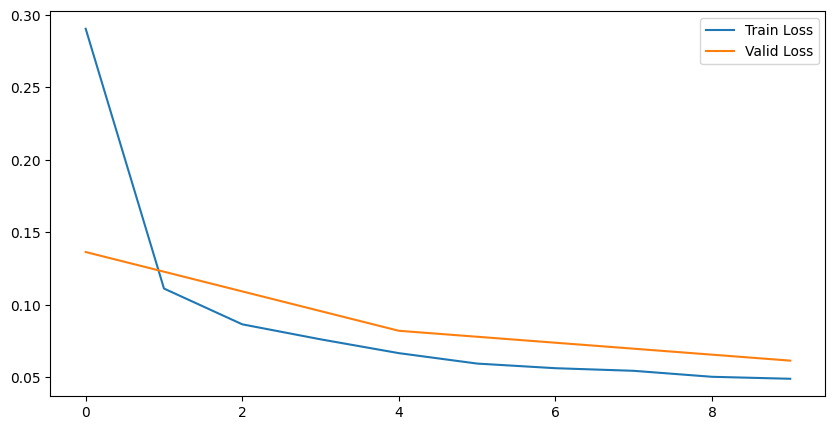

In [19]:
lenet5_trainer.plot_losses()

In [20]:
after_training_acc = lenet5_trainer.accuracy(Xval, yval)
print(f'Accuracy after training: {after_training_acc:.2%}')

Accuracy after training: 98.68%


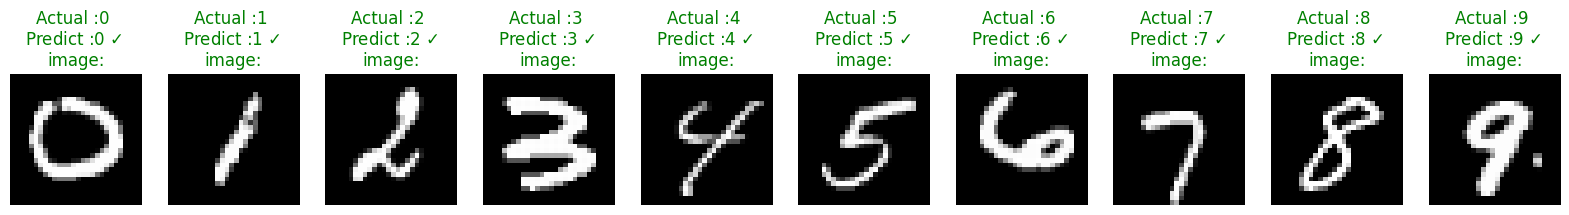

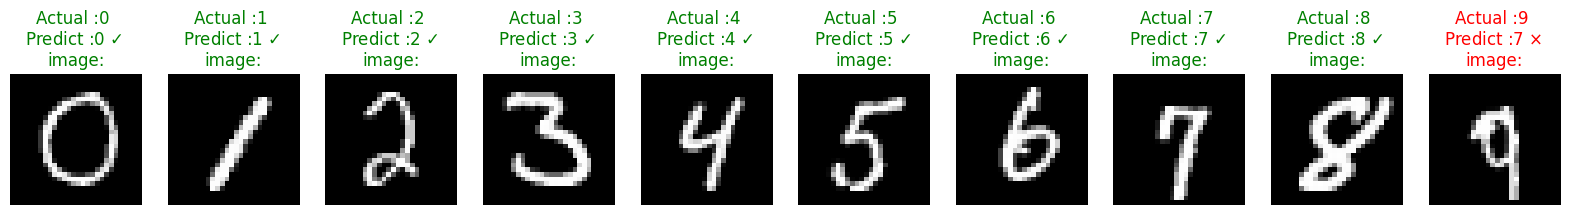

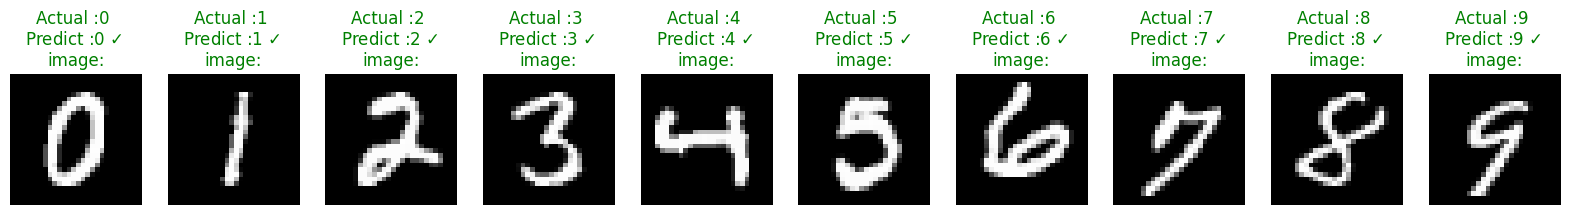

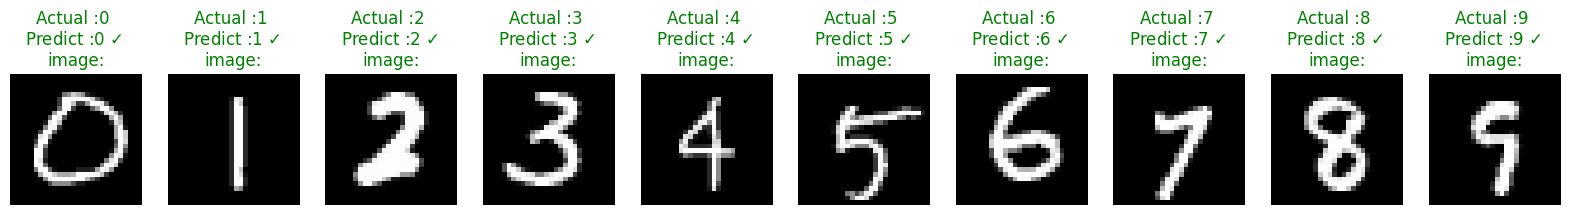

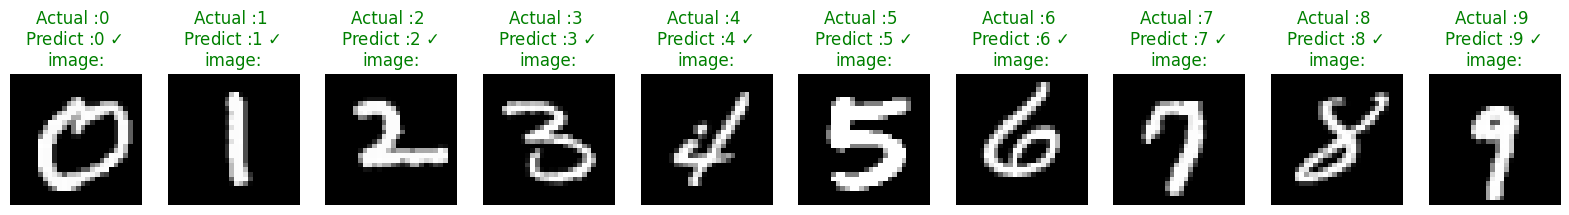

In [21]:
def compare_with_images(model, Xte, yte, lables = 10):
    fig = plt.figure(figsize=(20,2))
    for i in range(10):
        ax = fig.add_subplot(1, lables, i+1)
        imgs = Xte[yte == i]
        img_i = np.random.randint(imgs.shape[0])
        model_pred = model.predict(imgs[img_i].reshape(-1,1,28,28))
        lbls = yte[yte == i]
        
        ax.imshow(imgs[img_i], cmap='gray')
        
        if model_pred[0] == lbls[img_i]:
            ax.set_title(f'Actual :{int(lbls[img_i])} \nPredict :{int(model_pred[0])} $\\checkmark$ \nimage:', color='green')
        else:
            ax.set_title(f'Actual :{int(lbls[img_i])} \nPredict :{int(model_pred[0])} $\\times$ \nimage:', color='red')
        
        ax.axis('off')

compare_with_images(model, Xval, yval)


### Test Accuracy Report

In [22]:
Test_Accuracy = lenet5_trainer.accuracy(Xte, yte)
print(f'Accuracy after training: {Test_Accuracy:.2%}')

Accuracy after training: 98.66%


In [ ]:
compare_with_images(model, Xte, yte)
compare_with_images(model, Xte, yte)
compare_with_images(model, Xte, yte)
compare_with_images(model, Xte, yte)
compare_with_images(model, Xte, yte)